In [1]:
# import standard lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.preprocessing import MinMaxScaler

# necessary to import the own modules
import importlib 
import sys
sys.path.append("C:/Users/Leon/Documents/AI_project/AI_project")

# import own modules
from Data_analysis.utils import data_analysis as da

In [31]:
importlib.reload(da)

<module 'Data_analysis.utils.data_analysis' from 'C:\\Users/Leon/Documents/AI_project/AI_project\\Data_analysis\\utils\\data_analysis.py'>

## Load dataset

In [2]:
vegis_data = pd.read_csv("G:/Meine Ablage/KI_Projekt/Daten/vegis_traindata_280324.csv", index_col=None)
# store image names only for debugging reasons - then assignment possible
images = vegis_data.pop("Image")
display(vegis_data.head())

Hight  Width    R    G   B  green pixels  green onion pixels  ratio area  \
0    125     70  117   72  53             0                   0    0.647600   
1    100     97   93   63  61             0                  29    0.658969   
2    108    103  131   89  62             0                   3    0.780295   
3    115    104  126   88  64             0                  51    0.615217   
4    141    101  141  119  98             0                 223    0.362615   

   circularity  keypoints  mean keypoints  sym_vertical  sym_horizontal  \
0     0.497062         29        7.931567          0.80            0.74   
1     0.448148         29       12.216910          0.90            1.00   
2     0.826132         38       16.189532          0.86            0.88   
3     0.330286         22       16.265382          0.79            0.78   
4     0.112285         25        9.326496          0.45            0.43   

     Label  
0  Zwiebel  
1  Zwiebel  
2  Zwiebel  
3  Zwiebel  
4  Zwiebel

**first quick data overview**<br>
In total we have:
> - 14 columns
> - 2155 entries
> - no non-null entries

In [3]:
vegis_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Hight               2155 non-null   int64  
 1   Width               2155 non-null   int64  
 2   R                   2155 non-null   int64  
 3   G                   2155 non-null   int64  
 4   B                   2155 non-null   int64  
 5   green pixels        2155 non-null   int64  
 6   green onion pixels  2155 non-null   int64  
 7   ratio area          2155 non-null   float64
 8   circularity         2155 non-null   float64
 9   keypoints           2155 non-null   int64  
 10  mean keypoints      2155 non-null   float64
 11  sym_vertical        2155 non-null   float64
 12  sym_horizontal      2155 non-null   float64
 13  Label               2155 non-null   object 
dtypes: float64(5), int64(8), object(1)
memory usage: 235.8+ KB


**Check duplicated data**

In [4]:
vegis_data_copy = vegis_data.copy()
print("Number of duplicated rows: ", vegis_data_copy.duplicated().sum())
# get all duplicated rows
vegis_data_copy.loc[vegis_data_copy.duplicated(keep=False)]

# remove only the second occurrence
print("shape before: ", vegis_data_copy.shape)
vegis_data_copy = vegis_data_copy.drop_duplicates()
print("shape after: ", vegis_data_copy.shape)

Number of duplicated rows:  2
shape before:  (2155, 14)
shape after:  (2153, 14)


In [5]:
vegis_data_copy.columns

Index(['Hight', 'Width', 'R', 'G', 'B', 'green pixels', 'green onion pixels',
       'ratio area', 'circularity', 'keypoints', 'mean keypoints',
       'sym_vertical', 'sym_horizontal', 'Label'],
      dtype='object')

**create a new feature** ***width_height_ratio*** **from the** ***height*** **and** ***width*** **feature**<br>
background: the photos were taken in different distances to the vegi. The image_preproccesing locate the vegi in the image and draws a bounding box around it. If the photo was taken with a bigger distance to the vegi than the width and height from the bounding box is smaller and vice versa. The ratio of these two feature should compense the difference.

In [6]:
df = vegis_data_copy.assign(ratio_w_h = vegis_data_copy["Width"] / vegis_data_copy["Hight"])
df.head()
# for now keep the originally height and width feature because later we can check if there are now differences in the distribution

Hight  Width    R    G   B  green pixels  green onion pixels  ratio area  \
0    125     70  117   72  53             0                   0    0.647600   
1    100     97   93   63  61             0                  29    0.658969   
2    108    103  131   89  62             0                   3    0.780295   
3    115    104  126   88  64             0                  51    0.615217   
4    141    101  141  119  98             0                 223    0.362615   

   circularity  keypoints  mean keypoints  sym_vertical  sym_horizontal  \
0     0.497062         29        7.931567          0.80            0.74   
1     0.448148         29       12.216910          0.90            1.00   
2     0.826132         38       16.189532          0.86            0.88   
3     0.330286         22       16.265382          0.79            0.78   
4     0.112285         25        9.326496          0.45            0.43   

     Label  ratio_w_h  
0  Zwiebel   0.560000  
1  Zwiebel   0.970000  
2  Zwiebel   0.953704  
3  Zwiebel   0.904348  
4  Zwiebel   0.716312

**show the number of each vegi class**

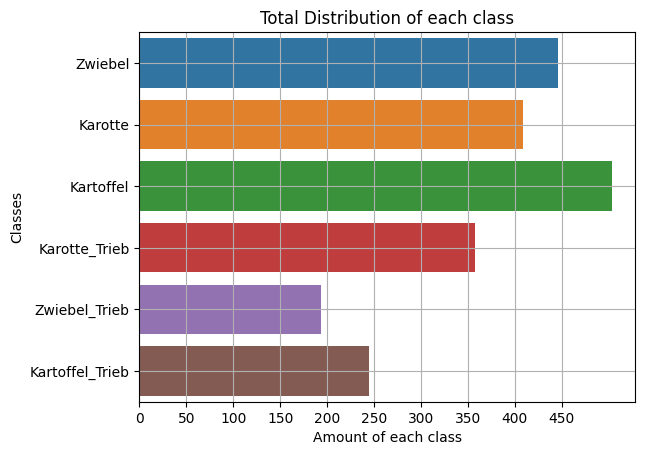

In [7]:
ax = sns.countplot(y=df['Label'], data=df)
plt.title("Total Distribution of each class")
plt.xlabel("Amount of each class")
plt.ylabel("Classes")
plt.grid()
plt.xticks(np.arange(0,500, step=50))
plt.show()

**First, get a total overview of the data distribution**<br>
- nearly every feature for each label has outliers in the data<br>
Why ? -> the image processing is still to inaccurate (not buggy). For instance, because of shadows within the image. The edge detection is not able to perfectly recognize the edge of the vegi and instead of it recognizes that the shadow is part of the vegi. The symmetry features aren't working perfectly because of the usage of the *segmentation algorithm*. It recognizes the edges quite reliably, but sometimes areas in the vegetables are segmented out, the reason for this is that there are reflective areas in the vegetables

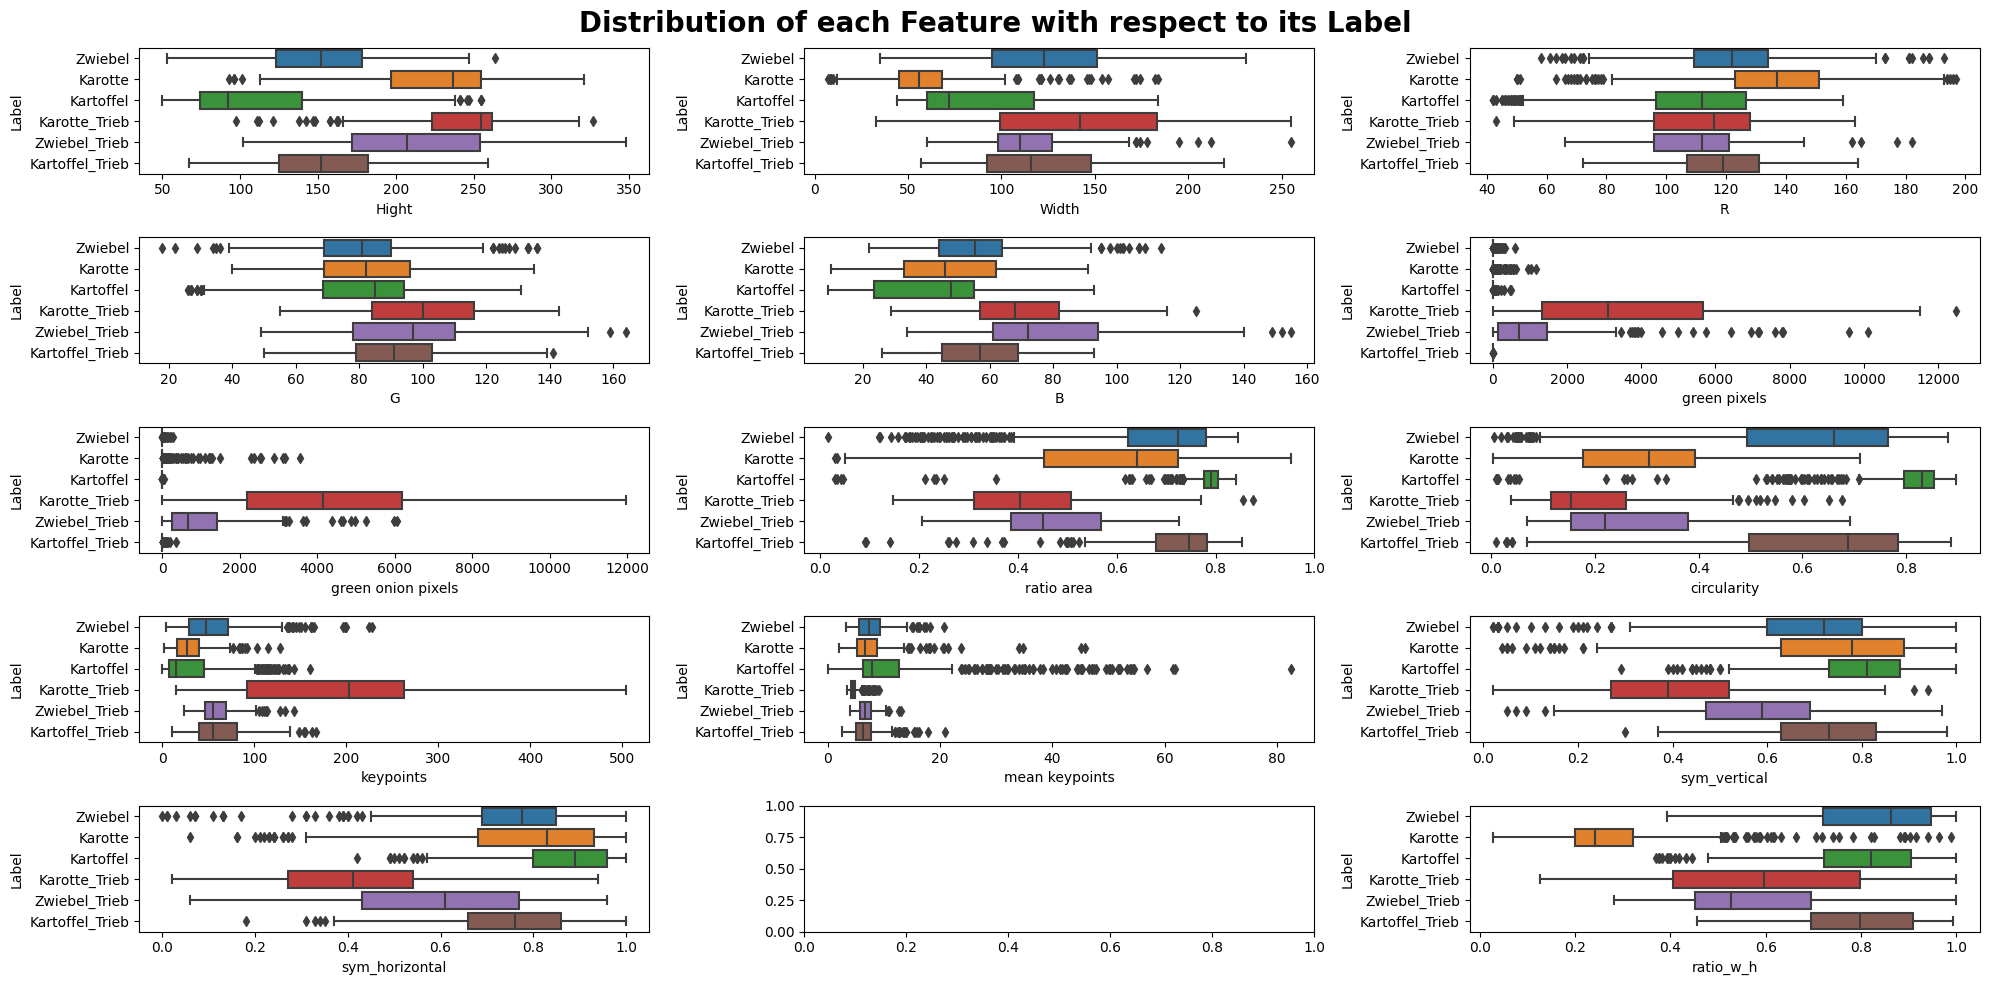

In [8]:
cols = df.columns.to_list()
fig, axes = plt.subplots(5, 3, figsize=(20, 10))
axes = axes.flatten()
for i, col in enumerate(df.columns):
    if col == "Label":
        continue
    sns.boxplot(data=df, y="Label", x=col, ax=axes[i])

plt.suptitle("Distribution of each Feature with respect to its Label", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

**examine the differences of** *green_pixels* **and** *green onion pixels* **and select the feature which can better distinct the labels**<br>
**expection:**<br> 
- value = 0 for Karotte, Zwiebel, Kartoffel<br>
- value > 0 for Karotte_Trieb, Zwiebel_Trieb, Kartoffel_Trieb<br>
<br>
**reality:**<br>
In the image processing I am using a color mask to find green pixels within the image and this is just an inaccurate approach, because color values (RGB, HSV) differs strongly between distinct images. For example, If the photo was taken in a well-lit or poorly lit room, the brightness has an impact on the color value. The color mask is not able to strictly seperate the pixels only by there color<br>
That's why, for some images (not all) for the Classes "Karrote, Zwiebel, Kartoffel" also contains green pixels<br>
<br>
**Feature selection**
For now I keep the Feature **"green onion pixels"**. Because:<br>
- for the classes "Karotte" and "Zwiebel" it makes approximately the same error like the Feature "green pixels"<br>
- for the classes "Karotte_Trieb" and "Zwiebel_Trieb" it works similar well<br>
- for the class "Kartoffel" it makes a way fewer errors than "green pixels<br>
- for the class "Kartoffel_Trieb" it finds a lot more green pixels<br>
The main idea of these two features was, with them we would may be able to distinguish between vegi good and vegi with tribe. That works for Zwiebel and Karotte, but of course tribes of a potato a not really green it is more kind of a white color. If it turns out that the remaining features can better distinguish between the classes than I will delete this feature<br>



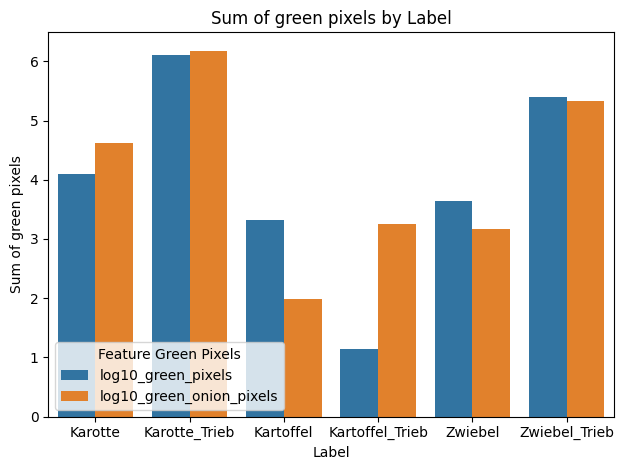

In [9]:
df_grouped = df.groupby('Label')[['green pixels', 'green onion pixels']].sum().reset_index()
# use log10 scale for the y-axis (sum of green pixels)
df_grouped = df_grouped.assign(log10_green_pixels=np.log10(df_grouped["green pixels"]),
                                log10_green_onion_pixels=np.log10(df_grouped["green onion pixels"])).drop(columns=["green pixels", "green onion pixels"])

# melt the dataframe it is easier to plot then
sum_df = df_grouped.melt(id_vars='Label', var_name='green', value_name='Sum')

sns.barplot(data=sum_df, x='Label', y='Sum', hue='green')
plt.xlabel('Label')
plt.ylabel('Sum of green pixels')
plt.title('Sum of green pixels by Label')
plt.legend(title='Feature Green Pixels', loc='lower left')
plt.tight_layout()
plt.show()



In [10]:
df = df.drop(columns="green pixels")


In [11]:
display(df.head())
label_col = df.pop("Label")
df = df.assign(Label=label_col)
display(df.head())

Hight  Width    R    G   B  green onion pixels  ratio area  circularity  \
0    125     70  117   72  53                   0    0.647600     0.497062   
1    100     97   93   63  61                  29    0.658969     0.448148   
2    108    103  131   89  62                   3    0.780295     0.826132   
3    115    104  126   88  64                  51    0.615217     0.330286   
4    141    101  141  119  98                 223    0.362615     0.112285   

   keypoints  mean keypoints  sym_vertical  sym_horizontal    Label  ratio_w_h  
0         29        7.931567          0.80            0.74  Zwiebel   0.560000  
1         29       12.216910          0.90            1.00  Zwiebel   0.970000  
2         38       16.189532          0.86            0.88  Zwiebel   0.953704  
3         22       16.265382          0.79            0.78  Zwiebel   0.904348  
4         25        9.326496          0.45            0.43  Zwiebel   0.716312

Hight  Width    R    G   B  green onion pixels  ratio area  circularity  \
0    125     70  117   72  53                   0    0.647600     0.497062   
1    100     97   93   63  61                  29    0.658969     0.448148   
2    108    103  131   89  62                   3    0.780295     0.826132   
3    115    104  126   88  64                  51    0.615217     0.330286   
4    141    101  141  119  98                 223    0.362615     0.112285   

   keypoints  mean keypoints  sym_vertical  sym_horizontal  ratio_w_h    Label  
0         29        7.931567          0.80            0.74   0.560000  Zwiebel  
1         29       12.216910          0.90            1.00   0.970000  Zwiebel  
2         38       16.189532          0.86            0.88   0.953704  Zwiebel  
3         22       16.265382          0.79            0.78   0.904348  Zwiebel  
4         25        9.326496          0.45            0.43   0.716312  Zwiebel

**visualize Data distribution with histograms**

Distribution plot for Zwiebel


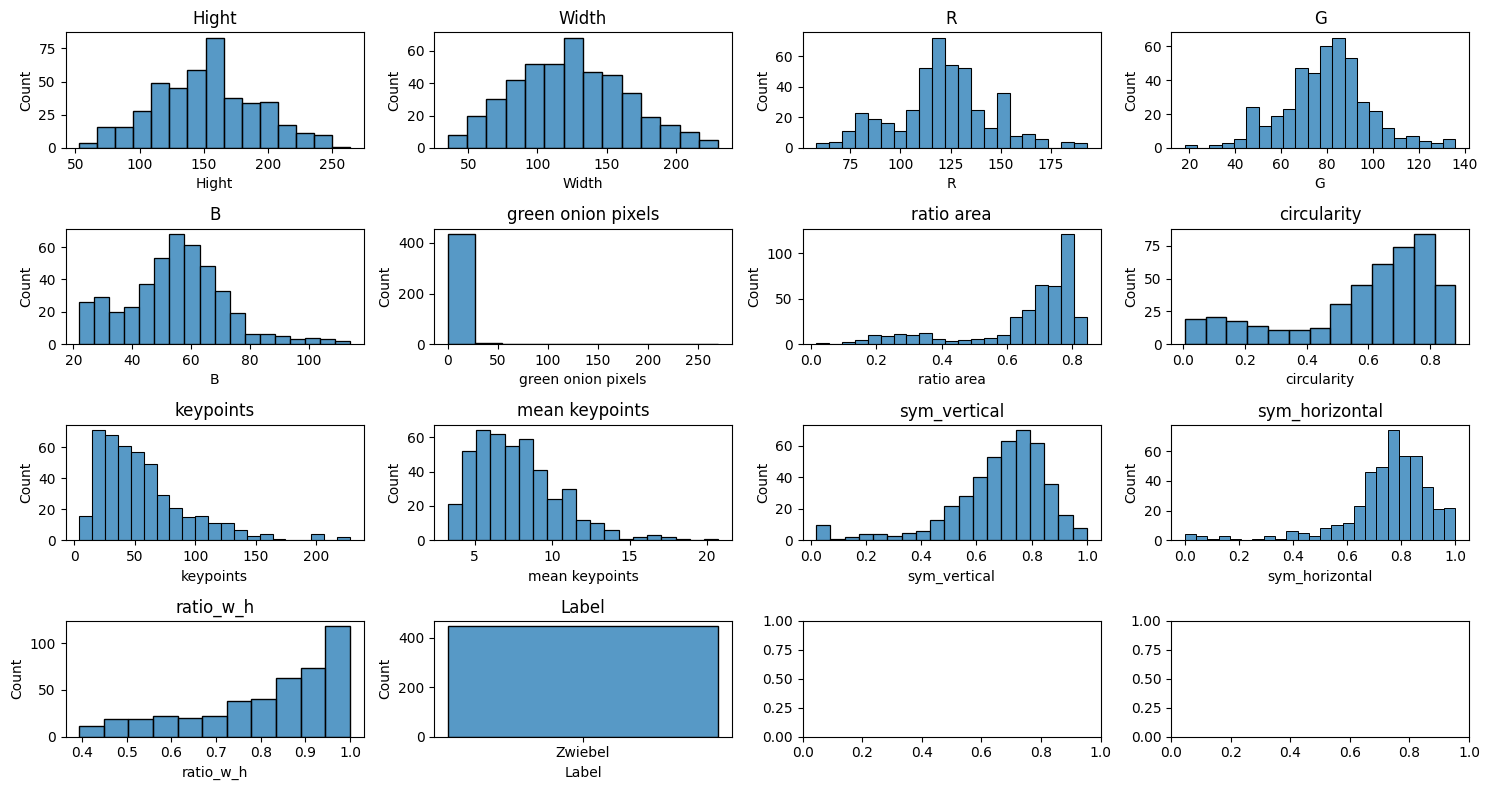




Distribution plot for Karotte


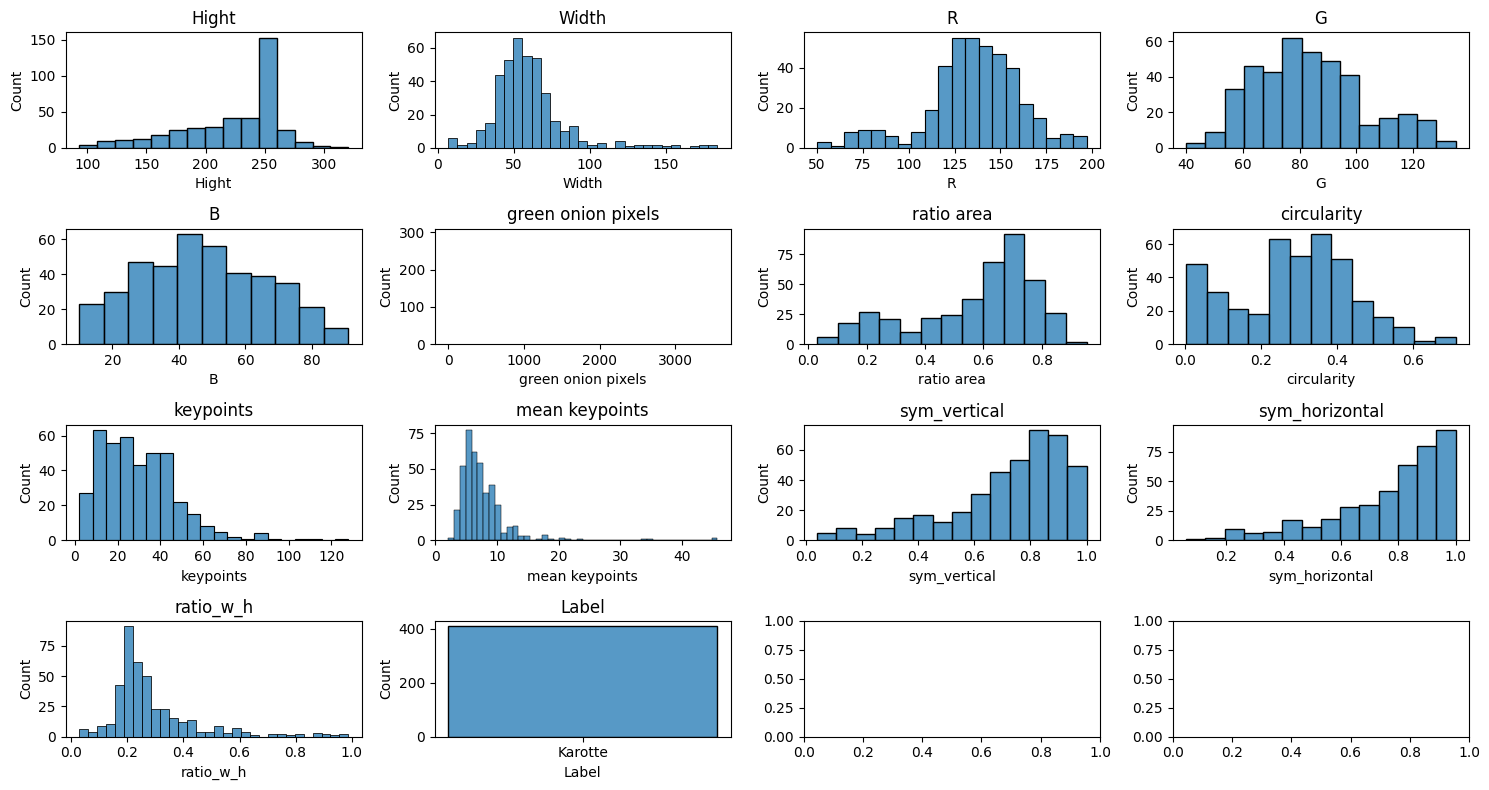




Distribution plot for Kartoffel


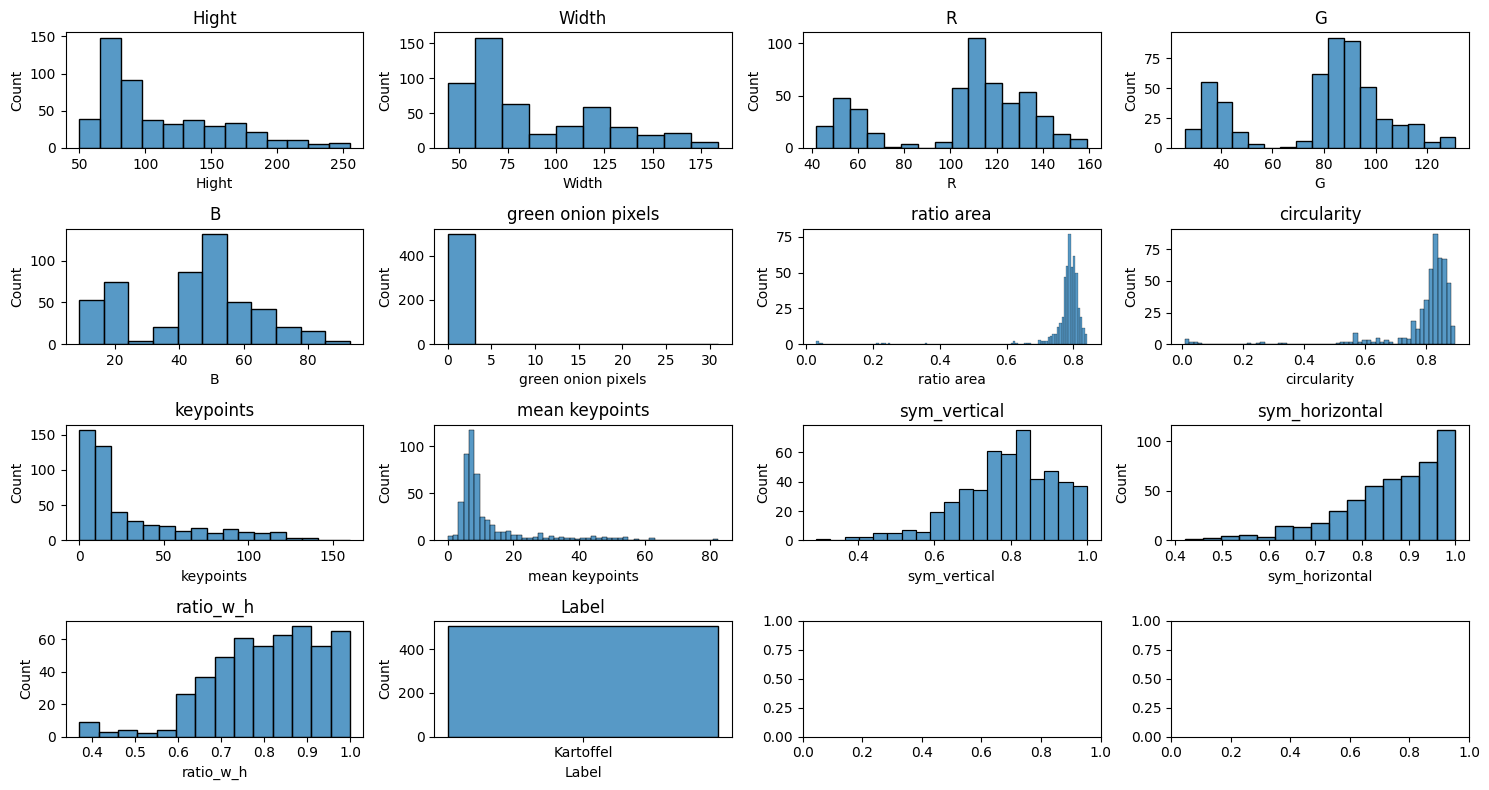




Distribution plot for Karotte_Trieb


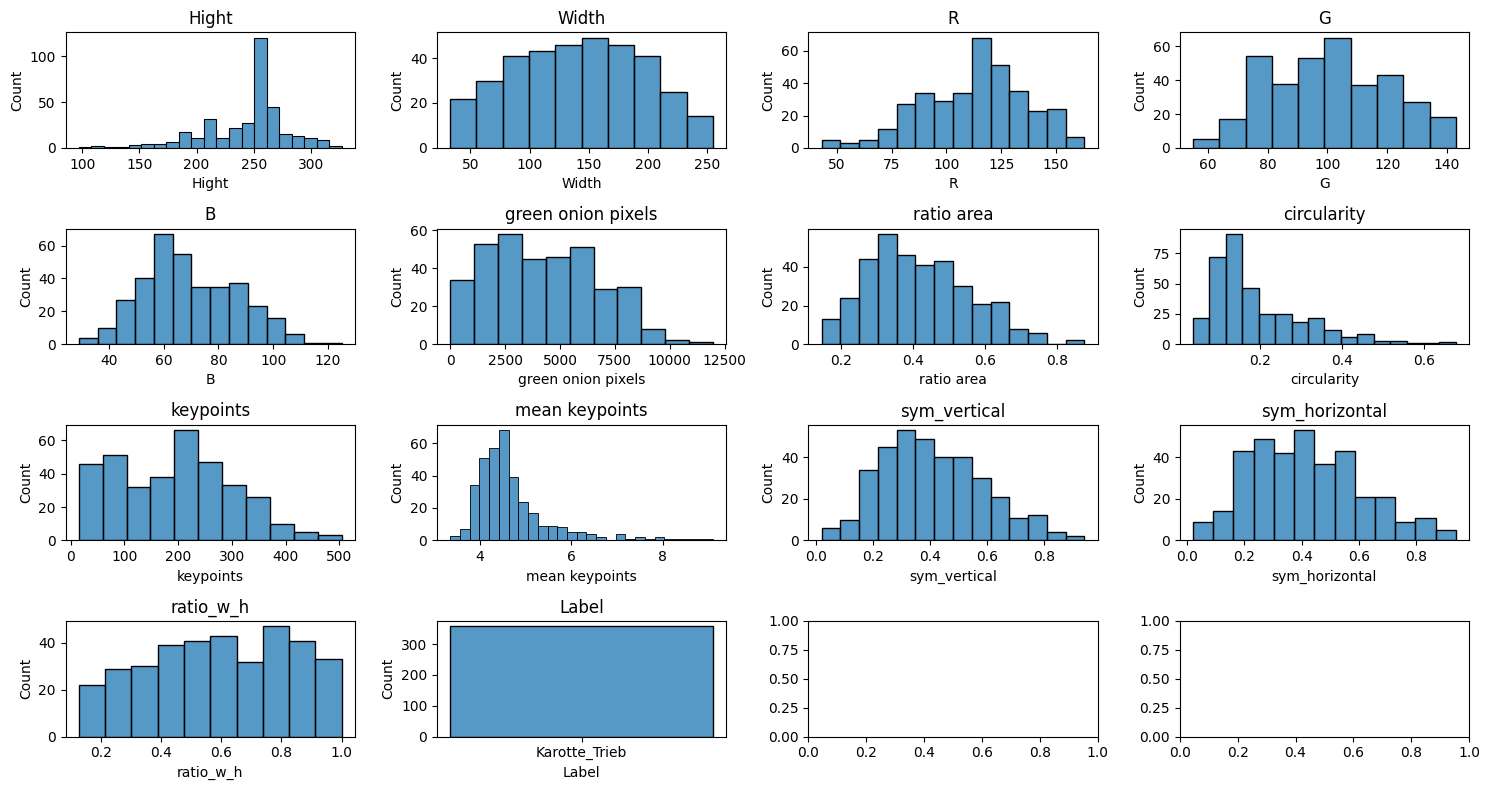




Distribution plot for Zwiebel_Trieb


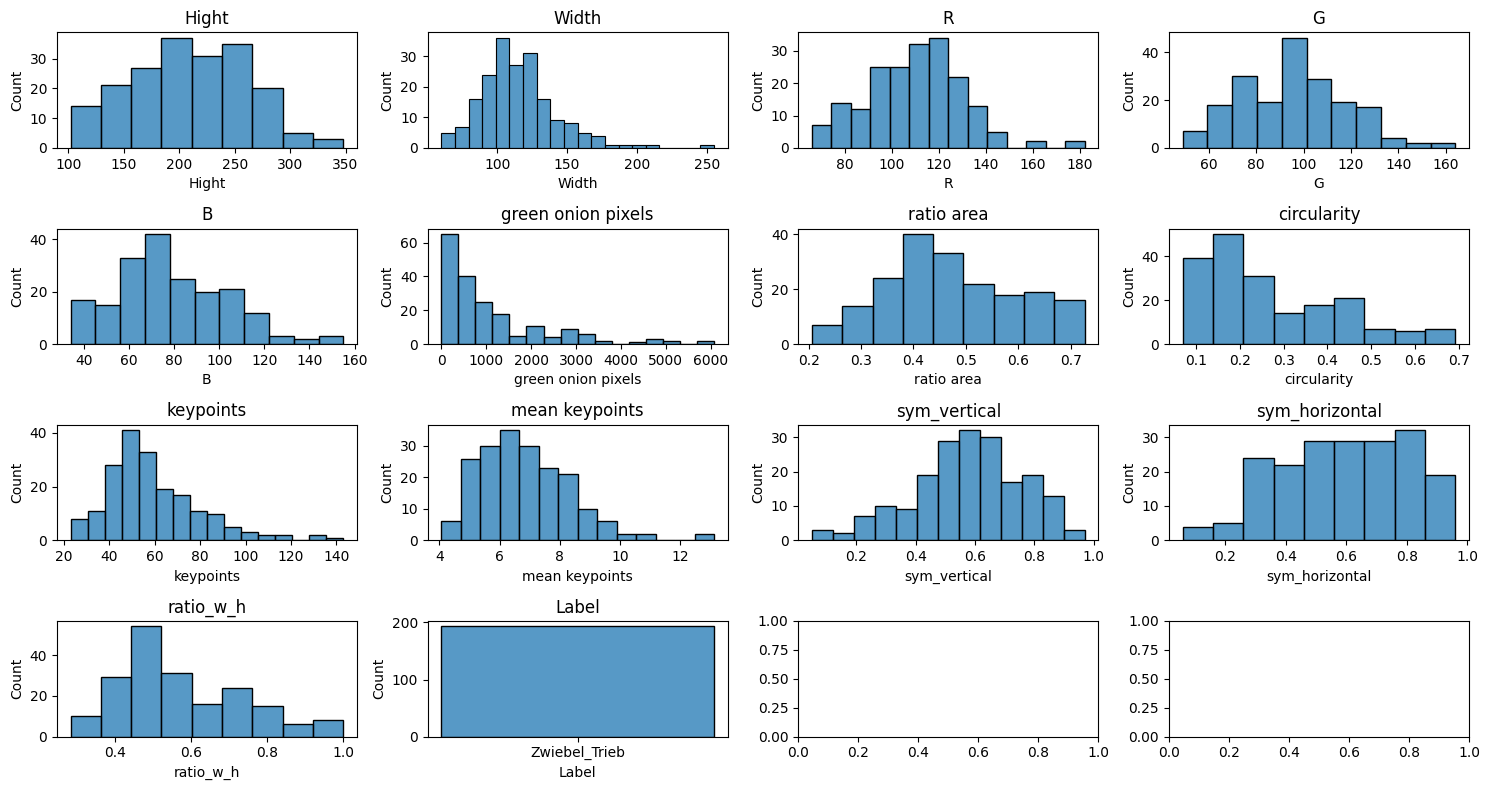




Distribution plot for Kartoffel_Trieb


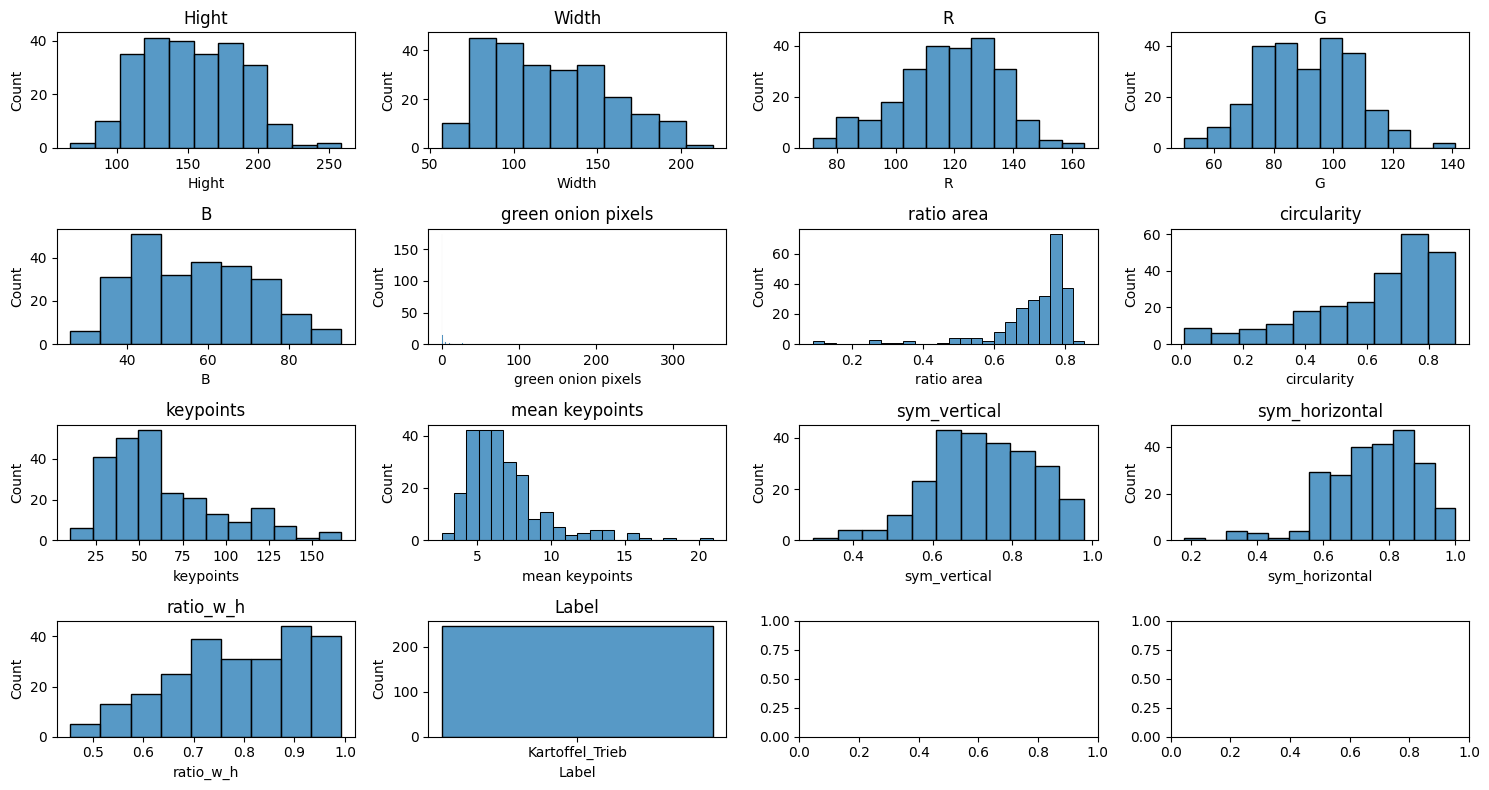

In [12]:
for vegi in df.Label.unique():
    sub_df =  df.loc[df["Label"] == vegi]
    #v_df_without_label = sub_df.drop(columns=["Label"])
    print(f"Distribution plot for {vegi}")
    cols = sub_df.columns
    fig, axes = plt.subplots(4, 4, figsize=(15, 8))
    axes = axes.flatten()
    for i, col in enumerate(cols):
        sns.histplot(sub_df[col], ax=axes[i], kde=False)
        axes[i].set_title(col)

    #fig.delaxes(axes[8])
    plt.tight_layout()
    plt.show()
    print("\n\n")

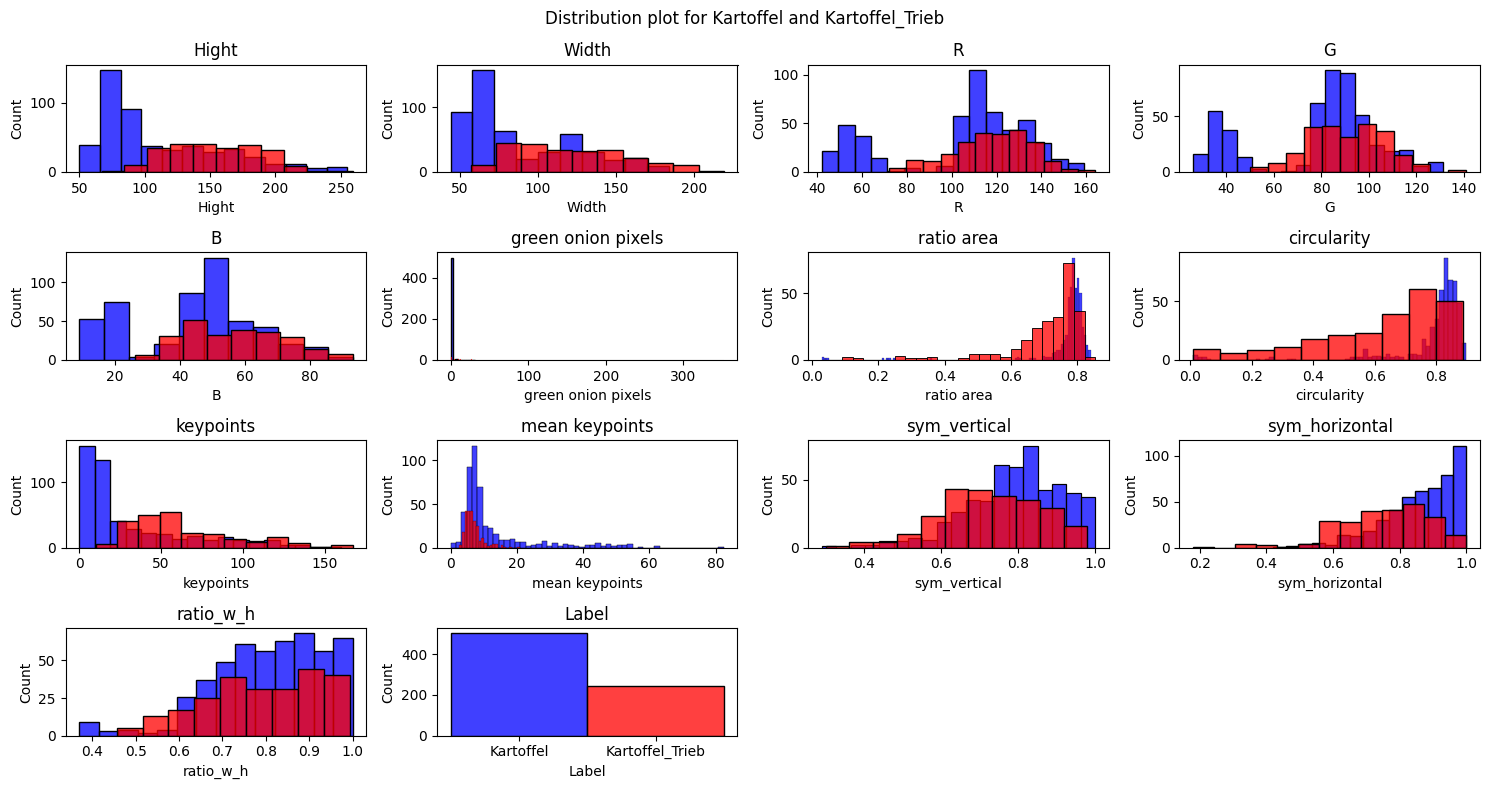

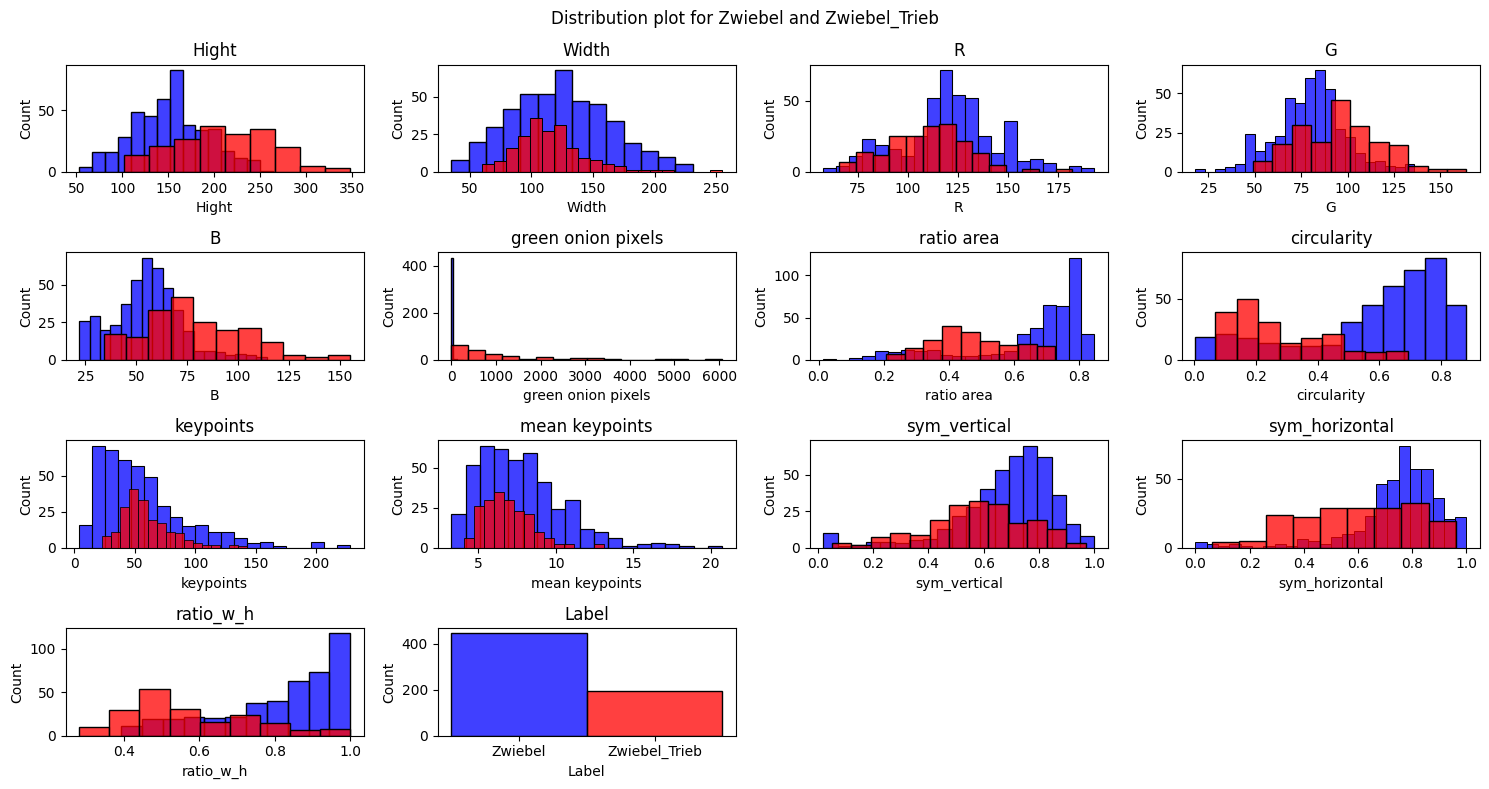

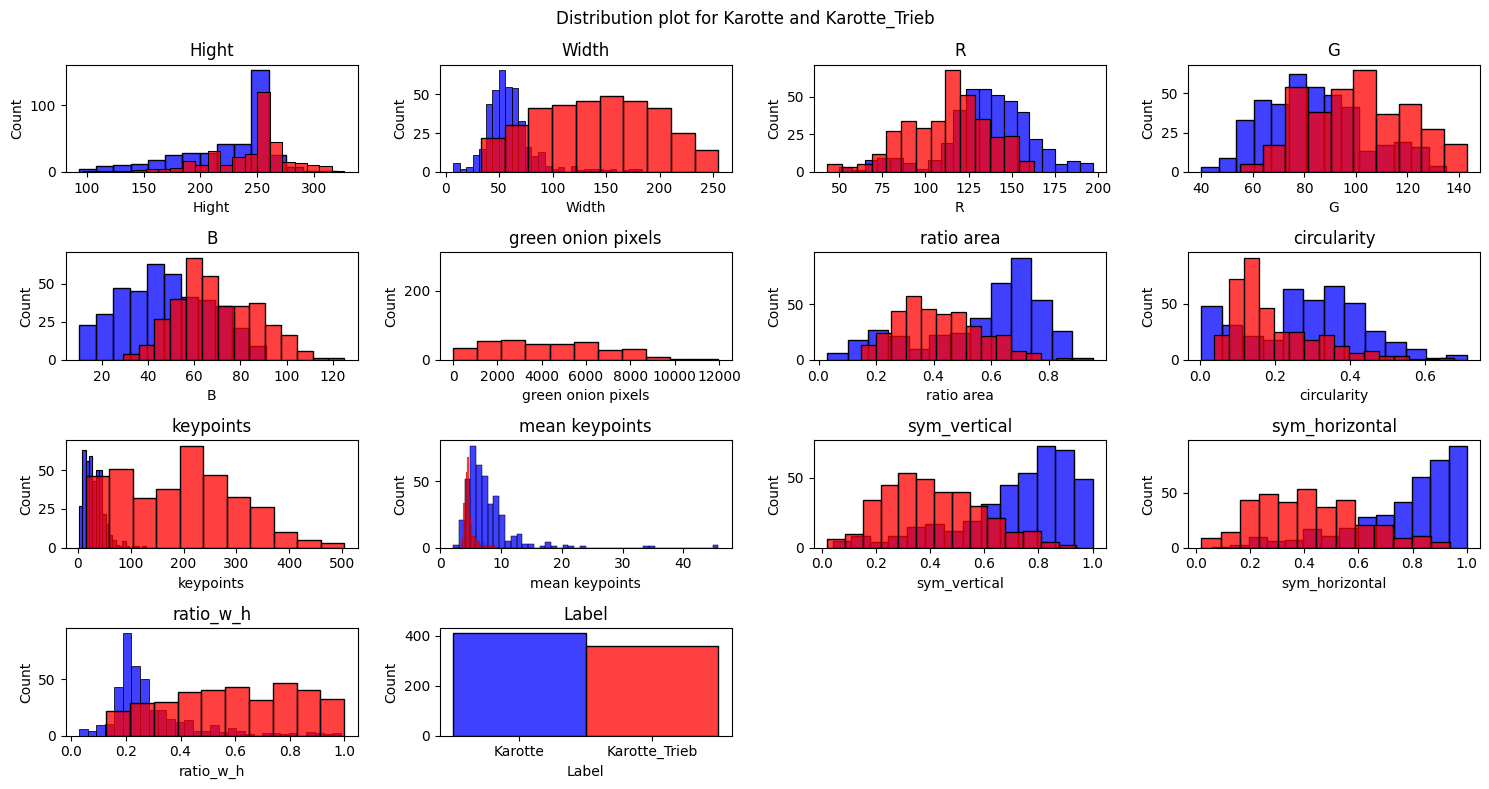

In [13]:
vegi_good = ["Kartoffel", "Zwiebel", "Karotte"]
vegi_bad = ["Kartoffel_Trieb", "Zwiebel_Trieb", "Karotte_Trieb"]
for good, bad in zip(vegi_good, vegi_bad):
    sub_df_good = df.loc[df["Label"] == good]
    sub_df_bad = df.loc[df["Label"] == bad]
    cols = sub_df_good.columns
    fig, axes = plt.subplots(4, 4, figsize=(15, 8))
    axes = axes.flatten()
    for i, col in enumerate(cols):
        sns.histplot(sub_df_good[col], ax=axes[i], kde=False, color="blue")
        sns.histplot(sub_df_bad[col], ax=axes[i], kde=False, color="red")
        axes[i].set_title(col)
        #axes[i].legend()

    fig.delaxes(axes[14])
    fig.delaxes(axes[15])
    #fig.legend(label=[good, bad])
    plt.suptitle(f"Distribution plot for {good} and {bad}")
    plt.tight_layout()
    plt.show()
    print("\n\n")

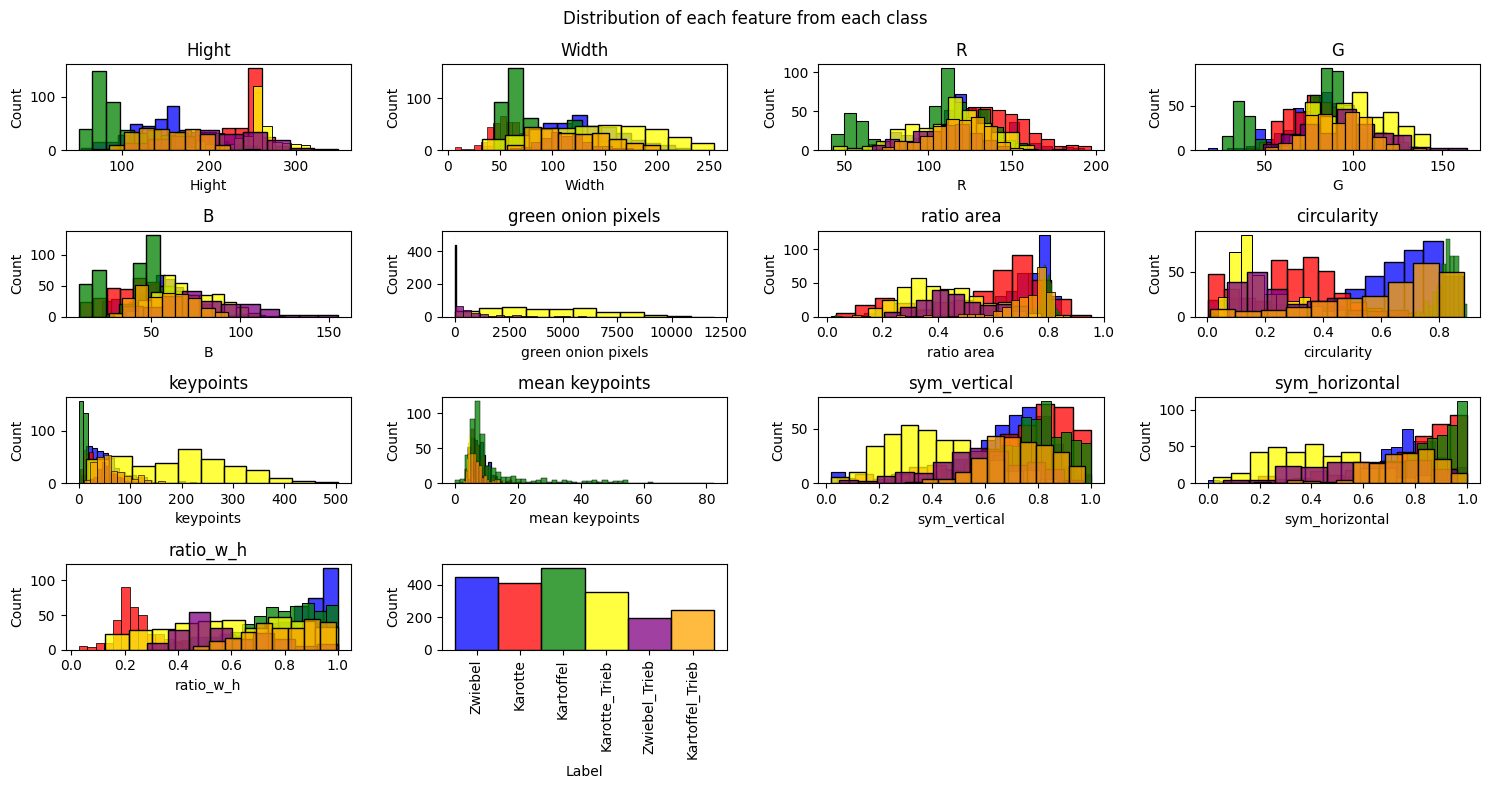

In [14]:
vegi_good = ["Kartoffel", "Zwiebel", "Karotte", "Kartoffel_Trieb", "Zwiebel_Trieb", "Karotte_Trieb"]
fig, axes = plt.subplots(4, 4, figsize=(15, 8))
axes = axes.flatten()
colors = ["blue", "red", "green", "yellow", "purple", "orange"]
for vegi, color in zip(df.Label.unique(), colors):
    sub_df = df.loc[df["Label"] == vegi]
    
    cols = sub_df_good.columns
    for i, col in enumerate(cols):
        sns.histplot(sub_df[col], ax=axes[i], kde=False, color=color)
        if col != "Label":
            axes[i].set_title(col)
        else:
            axes[i].tick_params(axis='x', rotation=90)
        #axes[i].legend()

fig.delaxes(axes[14])
fig.delaxes(axes[15])
#fig.legend(label=[good, bad])
plt.suptitle(f"Distribution of each feature from each class")
plt.tight_layout()
plt.show()
print("\n\n")

In [17]:
df = df.drop(columns=["Hight", "Width", "R", "G", "B", "keypoints", "mean keypoints"])
display(df.head())

green onion pixels  ratio area  circularity  sym_vertical  \
0                      0    0.647600     0.497062          0.80   
1                     29    0.658969     0.448148          0.90   
2                      3    0.780295     0.826132          0.86   
3                     51    0.615217     0.330286          0.79   
4                    223    0.362615     0.112285          0.45   
...                  ...         ...          ...           ...   
2150                   0    0.821168     0.720998          0.94   
2151                   0    0.685595     0.602414          0.77   
2152                   1    0.763811     0.623197          0.88   
2153                   0    0.772374     0.667829          0.85   
2154                   1    0.560878     0.327549          0.59   

      sym_horizontal  ratio_w_h            Label  
0               0.74   0.560000          Zwiebel  
1               1.00   0.970000          Zwiebel  
2               0.88   0.953704          Zwiebel  
3               0.78   0.904348          Zwiebel  
4               0.43   0.716312          Zwiebel  
...              ...        ...              ...  
2150            0.89   0.603175  Kartoffel_Trieb  
2151            0.85   0.634146  Kartoffel_Trieb  
2152            0.91   0.523179  Kartoffel_Trieb  
2153            0.87   0.559055  Kartoffel_Trieb  
2154            0.18   0.610687  Kartoffel_Trieb  

[2153 rows x 7 columns]

## pairplot (correlation plot)

In [26]:
df_2 = df.copy()
df_2 = df_2.assign(Classes=df_2.iloc[:,-1]).rename(columns={"Label": "Classes", "Classes": "Label"})
display(df_2.head())

df_2_pairplot = da.encoding_labels(df_2, "Classes", [0, 1, 2, 3, 4, 5])
df_2_pairplot = da.encoding_labels(df_2_pairplot, "Label", ["Karotte (0)", "Kartoffel (1)", "Zwiebel (2)", "Karotte_Trieb (3)", 
                                                            "Kartoffel_Trieb (4)", "Zwiebel_Trieb (5)"])

green onion pixels  ratio area  circularity  sym_vertical  sym_horizontal  \
0                   0    0.647600     0.497062          0.80            0.74   
1                  29    0.658969     0.448148          0.90            1.00   
2                   3    0.780295     0.826132          0.86            0.88   
3                  51    0.615217     0.330286          0.79            0.78   
4                 223    0.362615     0.112285          0.45            0.43   

   ratio_w_h  Classes    Label  
0   0.560000  Zwiebel  Zwiebel  
1   0.970000  Zwiebel  Zwiebel  
2   0.953704  Zwiebel  Zwiebel  
3   0.904348  Zwiebel  Zwiebel  
4   0.716312  Zwiebel  Zwiebel

In [28]:
encoding = dict(Karotte=0, Kartoffel=1, Zwiebel=2, Karotte_Trieb=3, Kartoffel_Trieb=4, Zwiebel_Trieb=5)
for vegi in df.Label.unique():
    df_2.loc[df_2["Classes"] == vegi, "Classes"] = encoding[vegi]

for vegi in df.Label.unique():
    df_2.loc[df_2["Label"] == vegi, "Label"] = f"{vegi}_({encoding[vegi]})"
display(df_2.head())
print(df_2.Classes.value_counts())

green onion pixels  ratio area  circularity  sym_vertical  sym_horizontal  \
0                   0    0.647600     0.497062          0.80            0.74   
1                  29    0.658969     0.448148          0.90            1.00   
2                   3    0.780295     0.826132          0.86            0.88   
3                  51    0.615217     0.330286          0.79            0.78   
4                 223    0.362615     0.112285          0.45            0.43   

   ratio_w_h Classes        Label  
0   0.560000       2  Zwiebel (2)  
1   0.970000       2  Zwiebel (2)  
2   0.953704       2  Zwiebel (2)  
3   0.904348       2  Zwiebel (2)  
4   0.716312       2  Zwiebel (2)

Classes
1    503
2    446
0    409
3    357
4    245
5    193
Name: count, dtype: int64


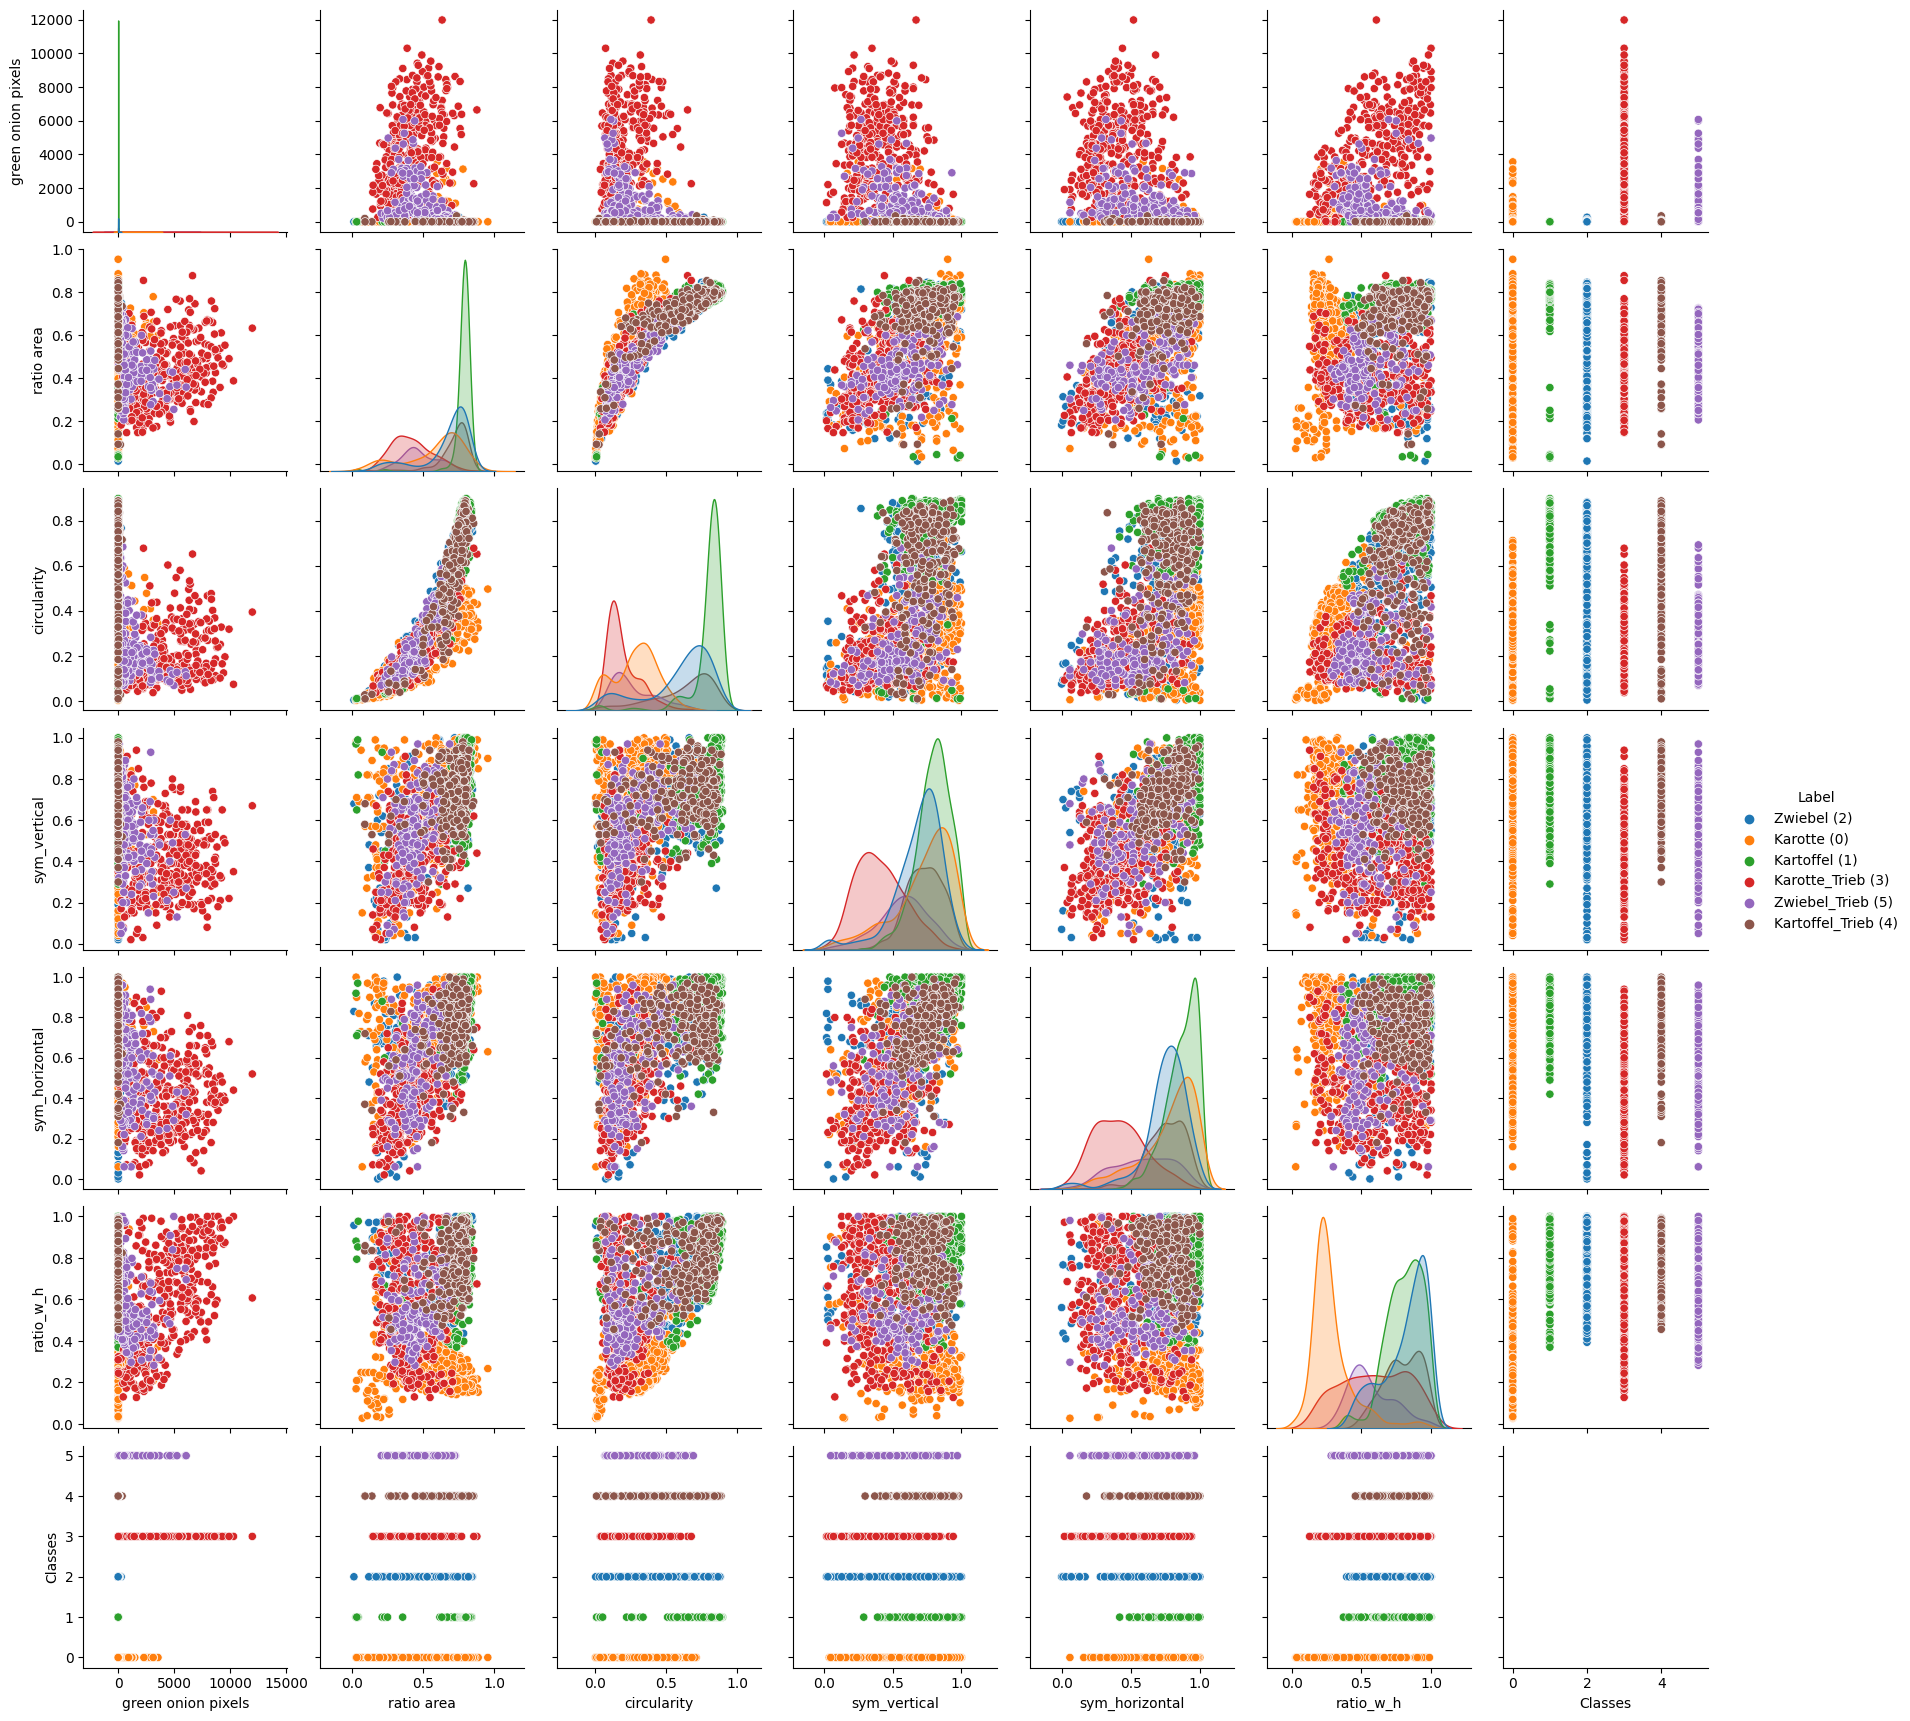

In [30]:
sns.pairplot(df_2, hue="Label", diag_kind="kde")

select only Karotte and Zwiebel

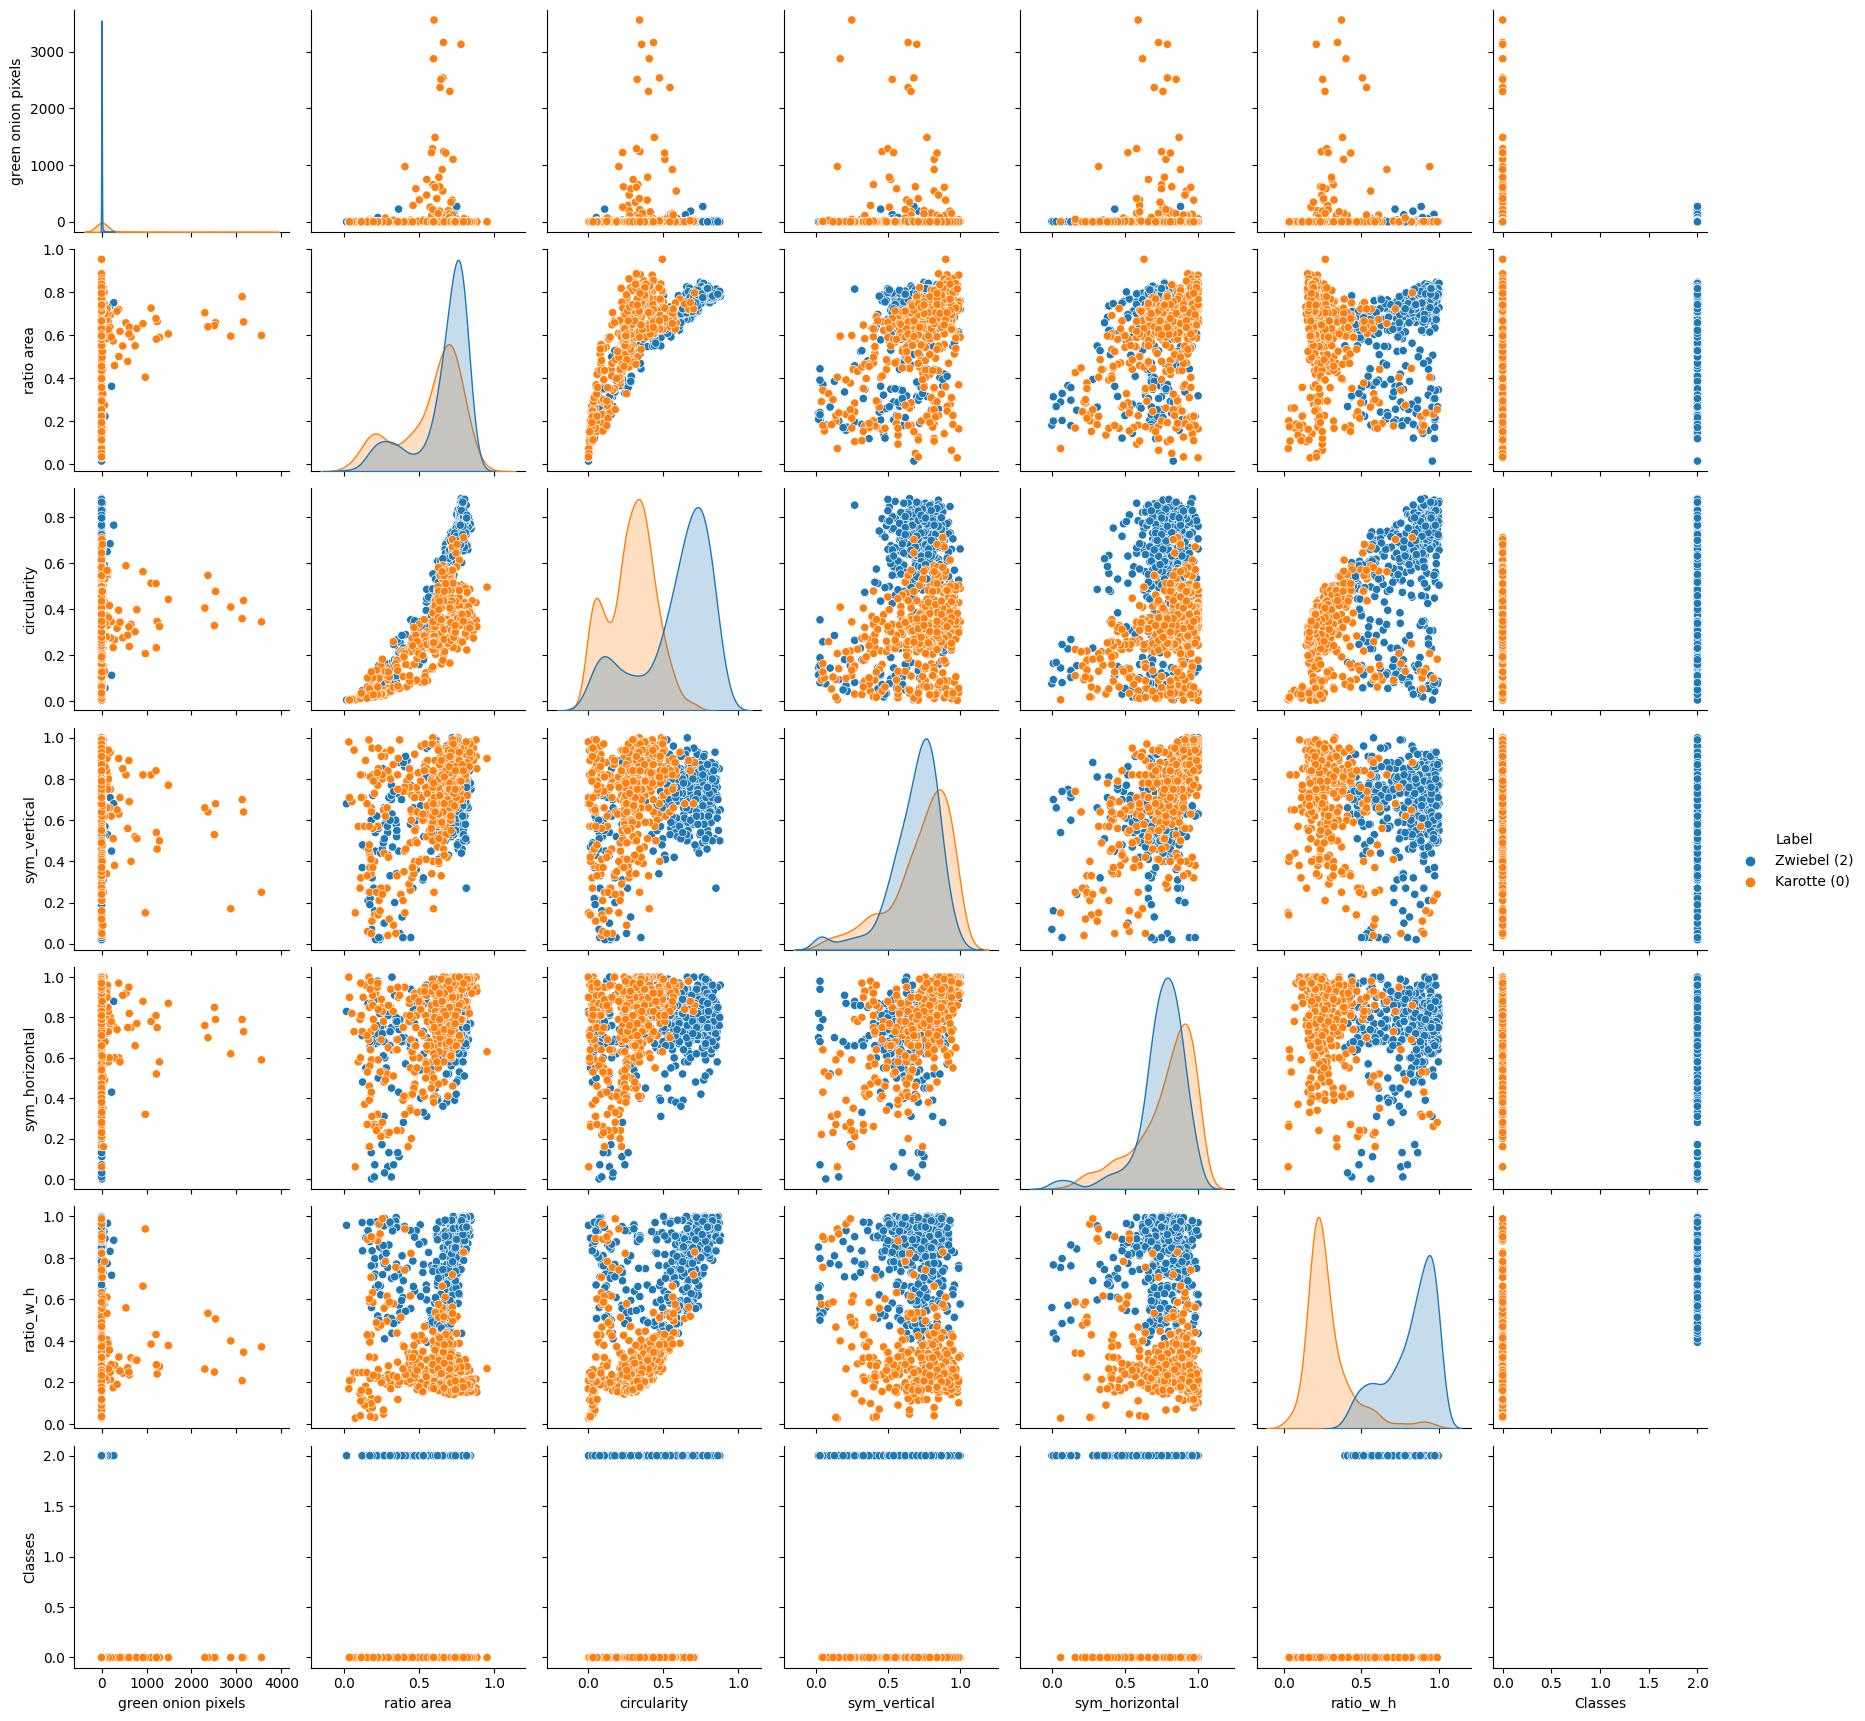

In [35]:
df_Karotte_Zwiebel = da.get_df_with_two_labels(df_2, 0, 2)
sns.pairplot(df_Karotte_Zwiebel, hue="Label", diag_kind="kde")

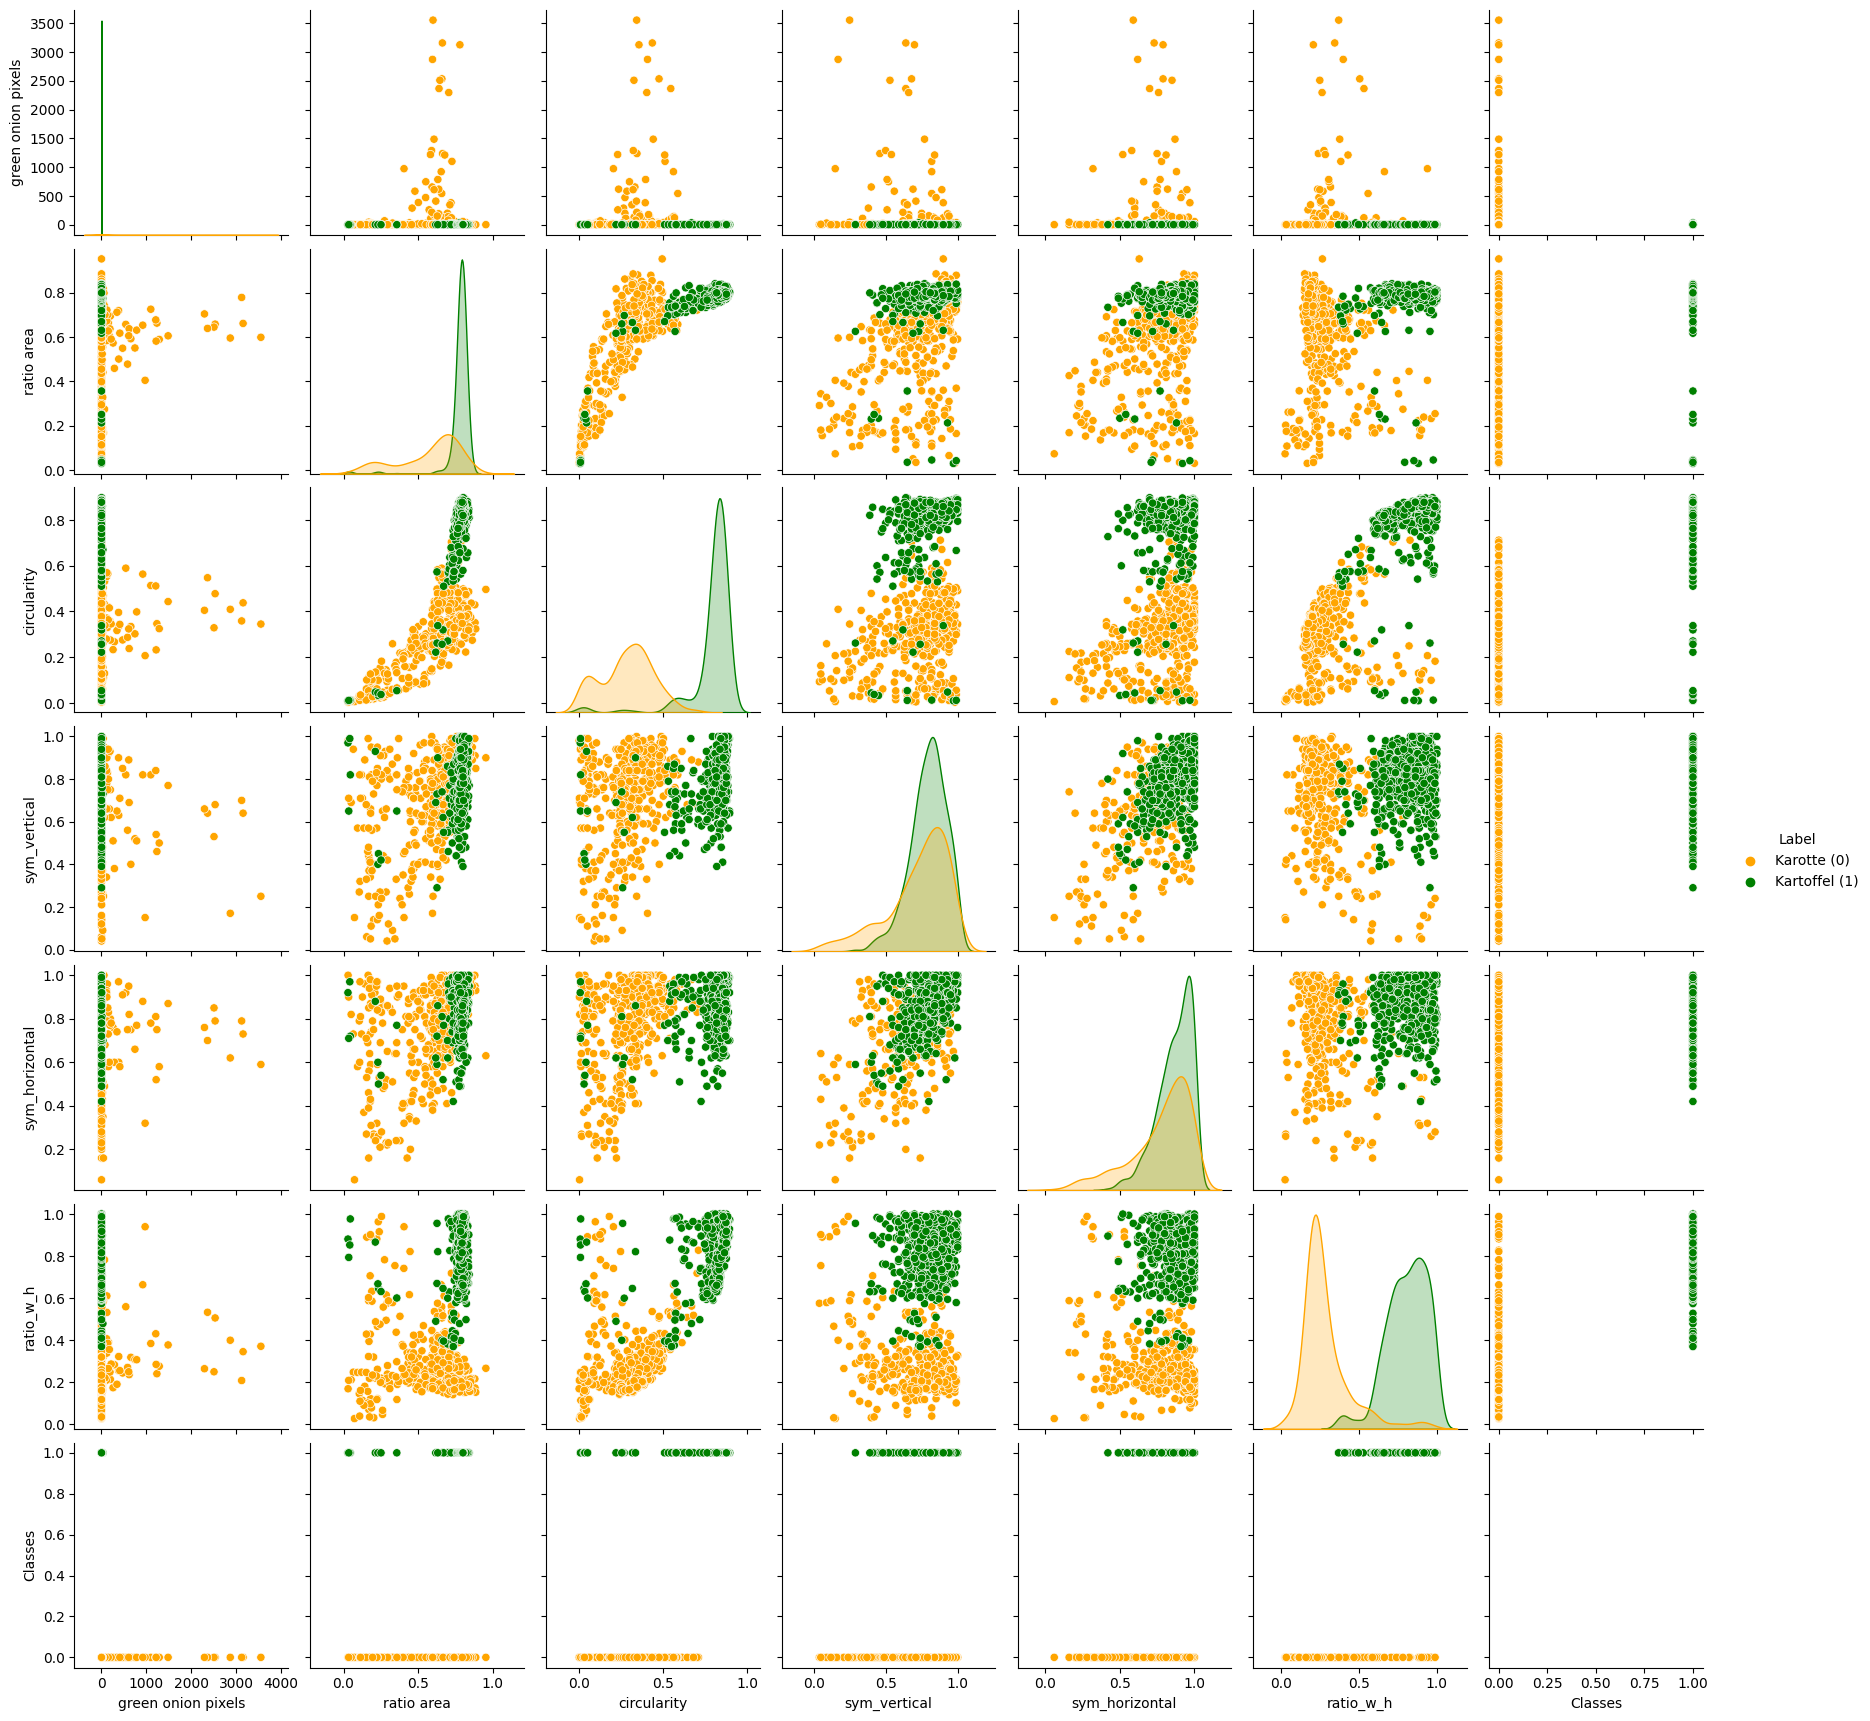

In [38]:
df_Karotte_Kartoffel = da.get_df_with_two_labels(df_2, 0, 1)
sns.pairplot(df_Karotte_Kartoffel, hue="Label", diag_kind="kde", palette={"Karotte (0)": "orange", "Kartoffel (1)": "green"})

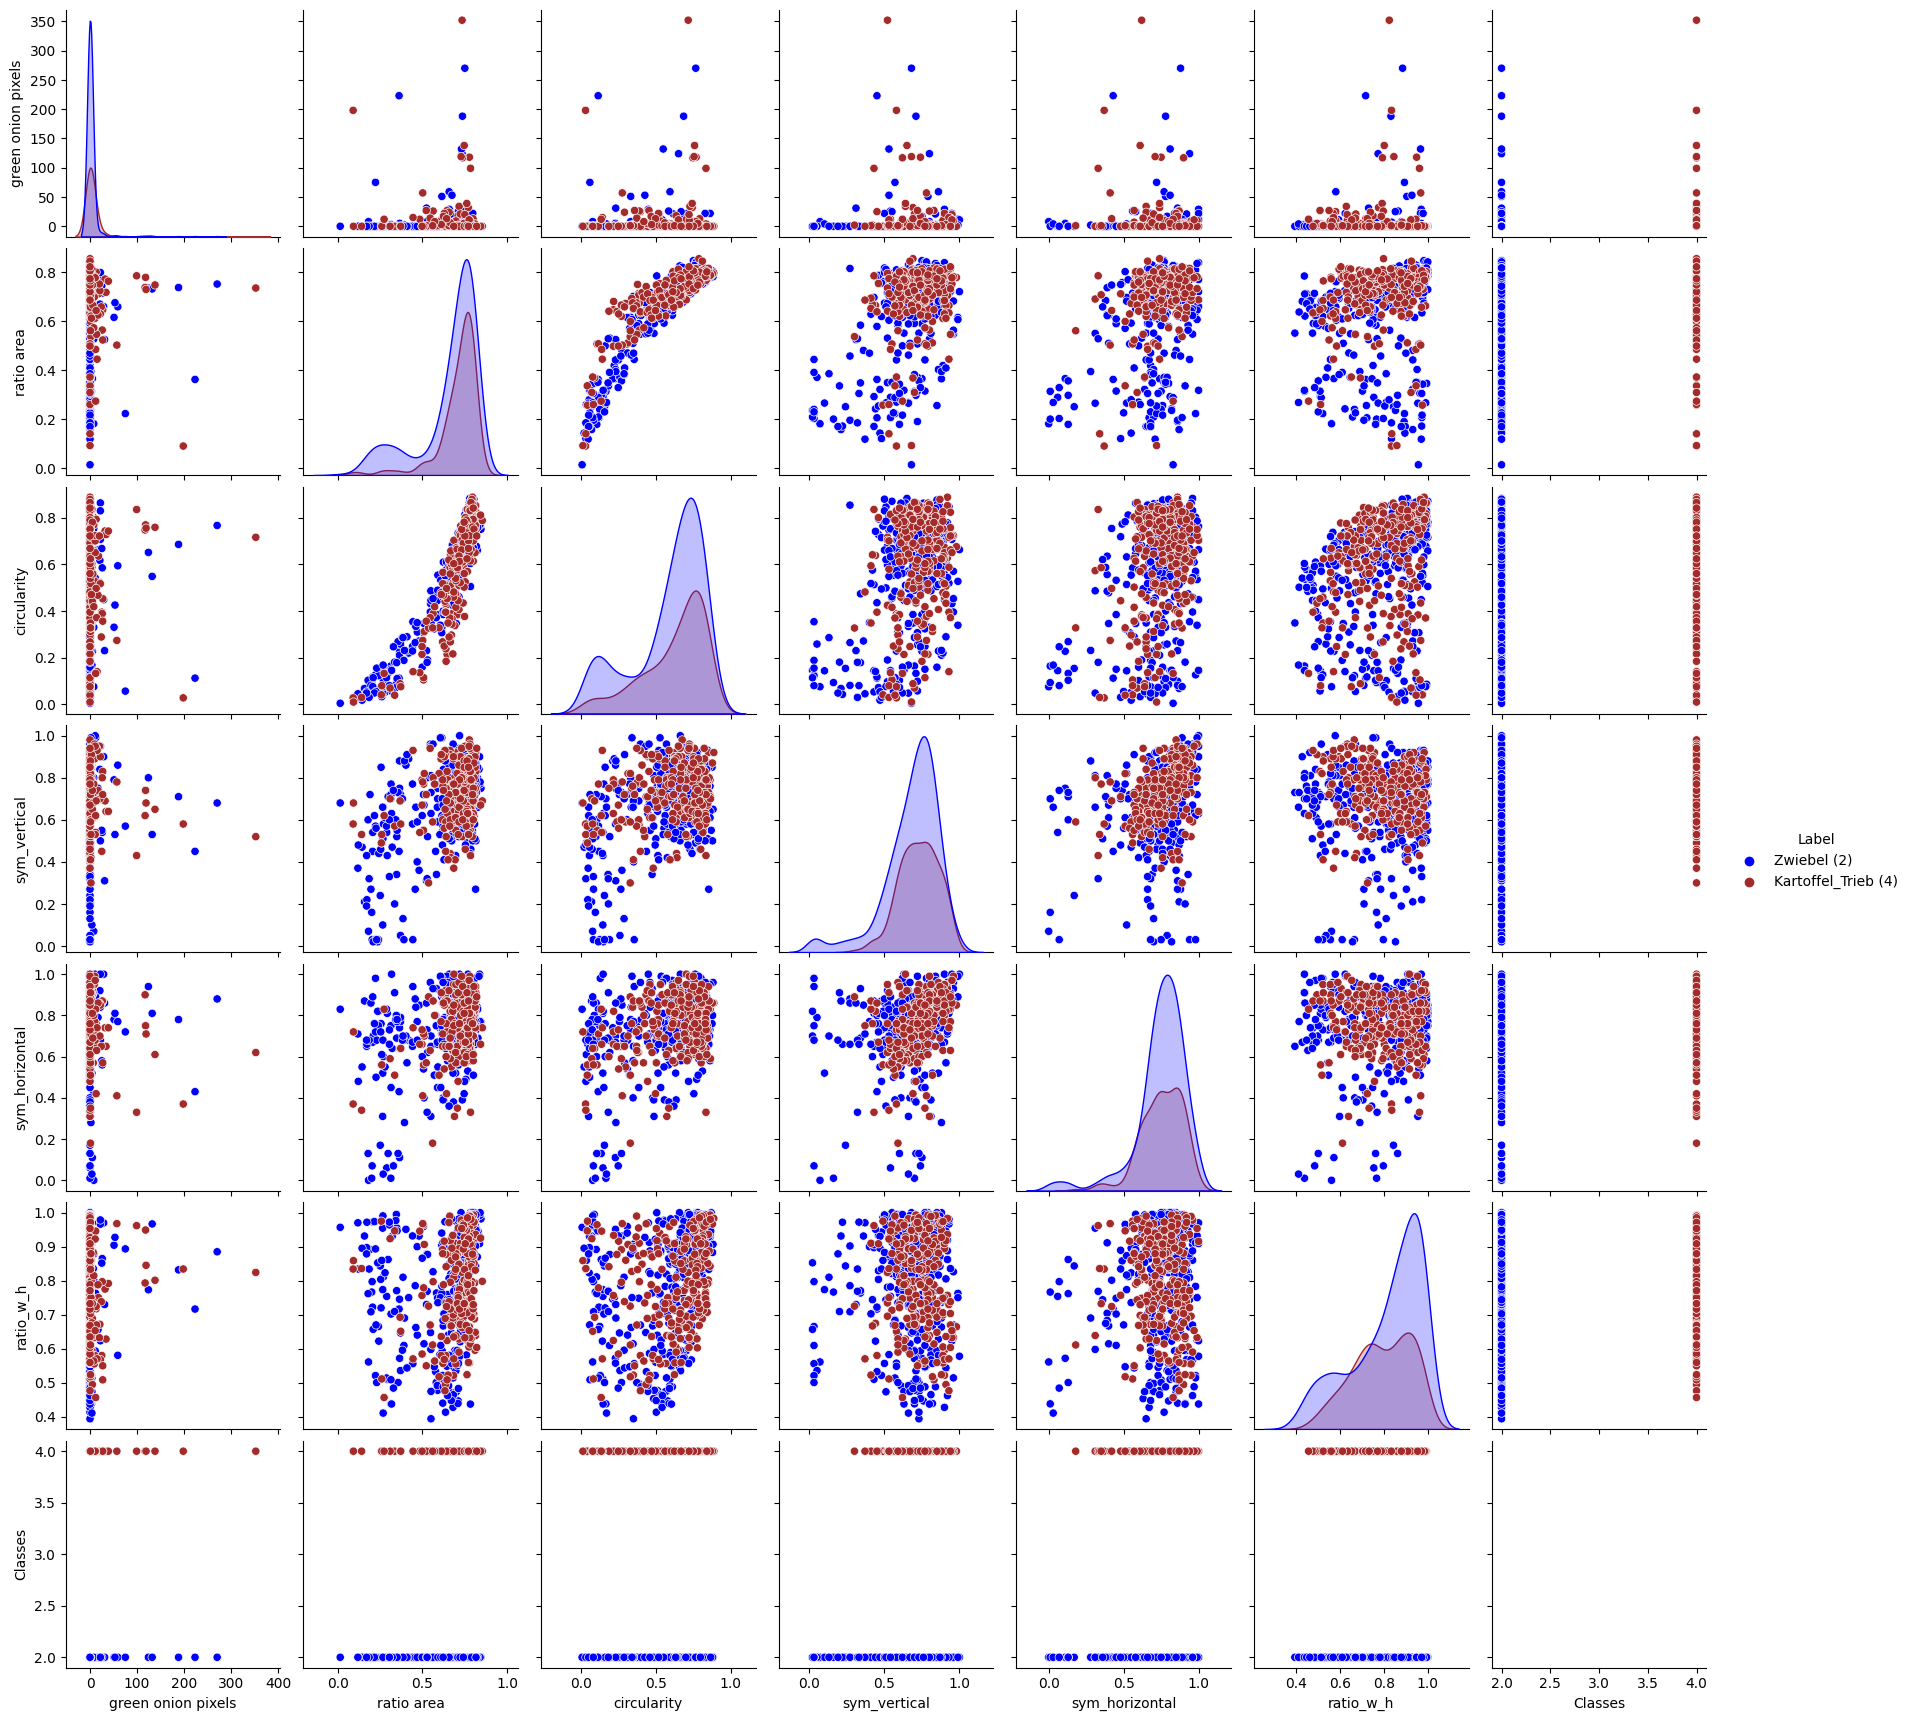

In [39]:
df_Zwiebel_Kartoffel_Trieb = da.get_df_with_two_labels(df_2, 2, 4)
sns.pairplot(df_Zwiebel_Kartoffel_Trieb, hue="Label", diag_kind="kde", palette={"Kartoffel_Trieb (4)": "brown", "Zwiebel (2)": "blue"})